<a href="https://colab.research.google.com/github/mobarakol/computer_vision_tutorial/blob/main/sfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gdown
url = 'https://drive.google.com/uc?id=1eygbXJvJbAWfBMlGxPl1-N_JSopi2RC9'
gdown.download(url,'P3Data.zip',quiet=True) 
!unzip -q P3Data.zip

In [8]:
!git clone https://github.com/dushyant6/Structure-From-Motion.git
%cd Structure-From-Motion/Code_Files/Phase1/

Cloning into 'Structure-From-Motion'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 123 (delta 1), reused 0 (delta 0), pack-reused 97
Receiving objects: 100% (123/123), 15.26 MiB | 15.35 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/Structure-From-Motion/Code_Files/Phase1


singular values of E [1.41573423e+01 1.39183522e+01 3.33006569e-15]
essential matrix [[ 0.00203389 -0.61653648  0.1168828 ]
 [ 0.66794481  0.0495678  -0.72790716]
 [-0.16328675  0.77487075  0.02595621]]
number of positive Z values 0
number of positive Z values 0
number of positive Z values 460
number of positive Z values 0
final P_dash matrix
 [[ 0.99680999  0.01802792  0.07774854 -0.77859941]
 [-0.02180387  0.99860962  0.0479939  -0.1467785 ]
 [-0.07677521 -0.04953601  0.99581713 -0.61011395]]
common point count 91
length of existing inliers 460
new length of inliers 506
list len 1 460
IMAGE NUMBER 3


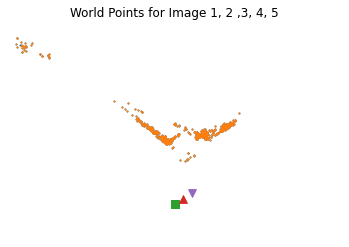

common point count 136
length of existing inliers 506
new length of inliers 536
list len 1 506
IMAGE NUMBER 4


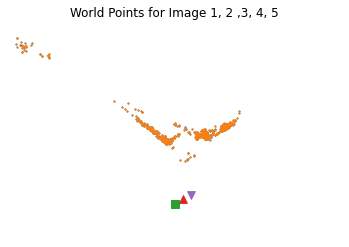

common point count 69
length of existing inliers 536
new length of inliers 540
list len 1 536
IMAGE NUMBER 5


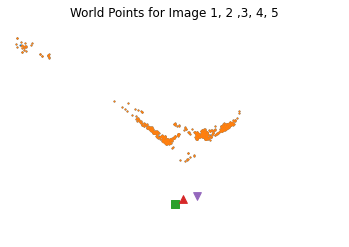

<Figure size 432x288 with 0 Axes>

In [21]:
import numpy as np
import scipy
import cv2 as cv
import matplotlib.pyplot as plt
from read_matches import read_match_file
from read_matches import find_common
from get_src_dst import create_src_dst
from RANSAC import RANSAC
from EssentialMatrixFromFundamentalMatrix import EssentialMatrixFromFundamentalMatrix
from EstimateFundamentalMatrix import getInliners
from ExtractCameraPose import ExtractCameraPose
from DisambiguateCameraPose import DisambiguateCameraPose
from NonlinearTriangulation import NonlinearTriangulation
from LinearTriangulation import LinearTriangulation
from PnPRANSAC import PnPRANSAC
from NonlinearPnP import NonlinearPnP
from BuildVisibilityMatrix import AdaptiveVisibility
from BundleAdjustment import Bundle_Error

def plot_images(image_number, P_matrix, K_matrix, image_points, world_points, string):
    b = 'P3Data/%d.png'%image_number
    img1 = cv.imread(b)
    img = img1.copy()
    for i in range(len(image_points)):
        cv.circle(img, (int(image_points[i][0]),int(image_points[i][1])), 3, [0,0,255], 1)
        x_proj = np.dot(np.dot(K_matrix, P_matrix), world_points[i])
        x_proj = x_proj/x_proj[2]
        cv.circle(img, (int(x_proj[0]), int(x_proj[1])), 2, [255,0,0], -1)
    string = 'output_images/' + string + '.png'
    cv.imwrite(string, img)

def error_func(world_point, src_point, dst_point, P, P_dash, K):
    err = []
    src_proj = np.dot(np.dot(K,P), world_point)
    src_proj = src_proj/src_proj[2]
    dst_proj = np.dot(np.dot(K, P_dash), world_point)
    dst_proj = dst_proj/dst_proj[2]
    err_src_x = src_point[0] - src_proj[0]
    err_src_y = src_point[1] - src_proj[1]
    err_src = np.sqrt(err_src_x**2 + err_src_y**2)
    err_dst_x = dst_point[0] - dst_proj[0]
    err_dst_y = dst_point[1] - dst_proj[1]
    err_dst = np.sqrt(err_dst_x**2 + err_dst_y**2)
    err.append(err_src_x)
    err.append(err_src_y)
    err.append(err_dst_x)
    err.append(err_dst_y)
    return err

#image number 1
file4 = open(r'P3Data/matching1.txt', 'r')
file4_lines = []
for count,line in enumerate(file4):
    file4_lines.append(line)
I = np.identity(3)

# 1) Import matches of first image with all other images
img_1to2, img_1to3, img_1to4, img_1to5, _, _, _, _, _, _  = read_match_file(1, file4_lines, count)
img1_matches = []
img1_matches.append(img_1to2)
img1_matches.append(img_1to3)
img1_matches.append(img_1to4)
img1_matches.append(img_1to5)
inliers_src = []
inliers_dst = []
world_points_old = []
world_points_current = []
P_set = []

# 2) Implement RANSAC to remove outliers from original matches
im1_12, im2_12 = create_src_dst(img_1to2)

# 3) Find fundamental matrix
inliers1_12, inliers2_12 = RANSAC(im1_12, im2_12, 11, 1000, 95)
sFinal,fFinal, inliers1_12f, inliers2_12f = getInliners(inliers1_12, inliers2_12)
inliers_src.append(inliers1_12f)
inliers_dst.append(inliers2_12f)
P = np.zeros([3,4])
P[:,0:3] = np.identity(3)

# 4) Essential matrix from fundamental matrix (intrinsic matrix)
K = [[531.122155322710, 0, 407.192550839899],
     [0, 531.541737503901, 313.308715048366],
     [0, 0, 1]]
E = EssentialMatrixFromFundamentalMatrix(fFinal,K)
print('essential matrix', E)

# 5) Find P_dash matrix
# P_dash, R and C contains pose matrix, rotation matrix, and translation vectors for all 4 configurations
C, R, P_dash = ExtractCameraPose(E, K)
P = np.zeros([3,4])
P[0][0] = P[1][1] = P[2][2] = 1
P_set.append(P)


# 6) Find real camera pose
Linear_World_points_12, real_pose = DisambiguateCameraPose(inliers1_12f, inliers2_12f, P, P_dash, K, R, C)
plot_images(1, P, K, inliers1_12f, Linear_World_points_12, 'img1 Linear world points')
plot_images(2, P_dash[real_pose], K, inliers2_12f, Linear_World_points_12, 'img2 Linear world points')
print('final P_dash matrix\n', P_dash[real_pose])
P_set.append(P_dash[real_pose])

# 7) find optimized world points
optimized_world_points_12 = NonlinearTriangulation(P, P_dash[real_pose], inliers1_12f, inliers2_12f, Linear_World_points_12, K)
new_non_linear_12 = []
for i in range(len(Linear_World_points_12)):
    optimized_list12 = scipy.optimize.least_squares(error_func, Linear_World_points_12[i], ftol = 0.00001, xtol=0.00001 ,args = (inliers1_12f[i], inliers2_12f[i], P, P_dash[real_pose], K))
    optim = optimized_list12.x
    optim = optim/ optim[3]
    new_non_linear_12.append(optim)
optimized_world_points_12 = new_non_linear_12
world_points_old = new_non_linear_12.copy()
plot_images(1, P, K, inliers1_12f, new_non_linear_12, 'img1 Non Linear world points')
plot_images(2, P_dash[real_pose], K, inliers2_12f, new_non_linear_12, 'img2 Non Linear world points')


#___________________________________________________________________________________________________________________________________
#prepare inputs for third image looping
Vis_Mat_Ad = np.ones([2,len(inliers1_12f)])
a = np.zeros_like(inliers1_12f[0])
P1_x = 0
P1_z = 0
C2 = -1* np.dot(np.linalg.inv(R[real_pose]), P_dash[real_pose][:,3])
P2_x = C2[0]
P2_z = C2[2]

#Register next images by looping
Linear_World_Points = Linear_World_points_12.copy()

new_inliers = []
new_inliers.append(inliers1_12f)
ref_inliers = []
common_inliers_src = []
common_inliers_dst = []
common_worldpoints = []
new_inliers_src = []
new_inliers_dst = []

All_Image_Points_list = []
a = np.zeros_like(inliers1_12f[0])
for i in range(len(inliers1_12f)):
    All_Image_Points_list.append((inliers1_12f[i], inliers2_12f[i], a, a, a))

for i in range(2,5):
    im_src, im_dst = create_src_dst(img1_matches[i-1])
    initial_src, initial_dst = RANSAC(im_src, im_dst, 11, 700, 95)
    _,_, inliers_src_f, inliers_dst_f = getInliners(initial_src, initial_dst)
    inliers_src.append(inliers_src_f)
    inliers_dst.append(inliers_dst_f)
    for j in range(len(new_inliers[i-2])):
        ref_inliers.append(new_inliers[i-2][j])
    
    common_inliers_dst_f, common_inliers_src_f, common_worldpoints_f, new_inliers_dst_f, new_inliers_src_f = find_common(inliers_src_f, ref_inliers, inliers_dst_f, world_points_old)
    
    PnP_RANSAC_Matrix = PnPRANSAC(common_worldpoints_f, common_inliers_dst_f, K)
    nonlinear_PnP_Undecomposed, decomposed_non_linear_PnP = NonlinearPnP(PnP_RANSAC_Matrix, common_worldpoints_f, common_inliers_dst_f, K)
    nonlinear_PnP_Undecomposed_isolated = np.dot(np.linalg.inv(K), nonlinear_PnP_Undecomposed)
    P_set.append(nonlinear_PnP_Undecomposed_isolated)

    new_world_points = LinearTriangulation(new_inliers_src_f, new_inliers_dst_f, P, nonlinear_PnP_Undecomposed_isolated, K)
    new_non_linear_x = []
    for j in range(len(new_world_points)):
        optimized_listx1 = scipy.optimize.least_squares(error_func, new_world_points[j], ftol = 1e-5, xtol=1e-5 ,args = (new_inliers_src_f[j], new_inliers_dst_f[j], P, nonlinear_PnP_Undecomposed_isolated, K))
        optim = optimized_listx1.x
        optim = optim/ optim[3]
        new_non_linear_x.append(optim)
    
    for j in range(len(new_non_linear_x)):
        world_points_old.append(new_non_linear_x[j])
        Linear_World_Points.append(new_world_points[j])
      
    im_num = i+1
    plot_images(i+1, nonlinear_PnP_Undecomposed, I, new_inliers_dst_f, new_world_points, 'img%d New world points Linear'%im_num)
    plot_images(i+1, nonlinear_PnP_Undecomposed, I, new_inliers_dst_f, new_non_linear_x, 'img%d New world points Non Linear'%im_num)
    plot_images(i+1, PnP_RANSAC_Matrix, I, common_inliers_dst_f, common_worldpoints_f, 'img%d PnP RANSAC'%im_num)
    plot_images(i+1, nonlinear_PnP_Undecomposed, I, common_inliers_dst_f, common_worldpoints_f, 'img%d PnP Non Linear'%im_num)
    
    # Append all image points
    old_image_points_count = len(All_Image_Points_list)
    print('length of existing inliers', old_image_points_count)
    for k in range(len(new_inliers_src_f)):
        All_Image_Points_list.append((new_inliers_src_f[k], a, a, a, a))
    All_Image_Points = All_Image_Points_list.copy()
    All_Image_Points = np.asarray(All_Image_Points)
    new_image_point_count = len(All_Image_Points_list)
    print('new length of inliers', len(All_Image_Points_list))
    
    count = 0
    for k in range(old_image_points_count, new_image_point_count):
        All_Image_Points[k][i] = new_inliers_dst_f[count]
        count += 1
        
    for k in range(len(world_points_old)):
        for j in range(len(common_worldpoints_f)):
            if (world_points_old[k][0] == common_worldpoints_f[j][0] and world_points_old[k][1] == common_worldpoints_f[j][1]):
                All_Image_Points[k][i][0] = common_inliers_dst_f[j][0]
                All_Image_Points[k][i][1] = common_inliers_dst_f[j][1]
    
    All_Image_Points_list = list(All_Image_Points)
    
    PSet = np.asarray(P_set)
    P_size = PSet.shape
    # 10) Visibility matrix
    Vis_Available = Vis_Mat_Ad

    list_len2 = len(new_inliers_dst_f)
    Vis_Mat_Ad = AdaptiveVisibility(i+1, Vis_Available, world_points_old, list_len2, common_worldpoints_f)
    #create initial parameter list
    WorldSet = np.asarray(world_points_old)
    initial_list = np.hstack((PSet.ravel(), WorldSet.ravel()))
    W_size = WorldSet.shape       
    optimized_list = scipy.optimize.least_squares(Bundle_Error, initial_list, xtol=1e-5, args =[All_Image_Points, Vis_Mat_Ad, P_size, W_size, K])
    P_and_W = optimized_list.x
    PSet_BA = np.reshape(P_and_W[:P_size[0]*3*4], P_size)
    WorldSet_BA = np.reshape(P_and_W[P_size[0]*3*4: len(initial_list)], W_size)

    new_inliers.append(new_inliers_src_f)    
    print('IMAGE NUMBER', im_num)
    
    #scatter plot save    
    World_x = np.zeros([len(world_points_old),1])
    World_z = np.zeros([len(world_points_old),1])
    Linear_World_x = np.zeros([len(Linear_World_Points),1])
    Linear_World_z = np.zeros([len(Linear_World_Points),1])
    for k in range(len(world_points_old)):
        World_x[k], World_z[k] = world_points_old[k][0], world_points_old[k][2]
        Linear_World_x[k], Linear_World_z[k] = Linear_World_Points[k][0], Linear_World_Points[k][2]

    plt.scatter(World_x, World_z, s = 1)
    plt.scatter(Linear_World_x, Linear_World_z, s = 1)
    plt.scatter(P1_x, P1_z, s = 60, marker="s")
    plt.scatter(P2_x, P2_z, s = 60, marker="^")
    #------------------------------------------------------------------------------------------------------------------------------
    R3 = nonlinear_PnP_Undecomposed_isolated[:,0:3]
    C3 = -1* np.dot(np.linalg.inv(R3), nonlinear_PnP_Undecomposed_isolated[:,3])
    P3_x = C3[0]
    P3_z = C3[2]
    plt.scatter(P3_x, P3_z, s = 60, marker="v")
    plt.title('World Points for Image 1, 2 ,3, 4, 5')
    plt.axis('off')
    plt.xlim([-15, 15])
    plt.ylim([-5, 25])
    plt.show()
    plt.savefig('output_images/XvZ.jpg')


In [22]:
#image number 1
file4 = open(r'P3Data/matching1.txt', 'r')
file4_lines = []
for count,line in enumerate(file4):
    file4_lines.append(line)
I = np.identity(3)

# 1) Import matches of first image with all other images
img_1to2, img_1to3, img_1to4, img_1to5, _, _, _, _, _, _  = read_match_file(1, file4_lines, count)
img1_matches = []
img1_matches.append(img_1to2)
img1_matches.append(img_1to3)
img1_matches.append(img_1to4)
img1_matches.append(img_1to5)
inliers_src = []
inliers_dst = []
world_points_old = []
world_points_current = []
P_set = []

# 2) Implement RANSAC to remove outliers from original matches
im1_12, im2_12 = create_src_dst(img_1to2)

# 3) Find fundamental matrix
inliers1_12, inliers2_12 = RANSAC(im1_12, im2_12, 11, 1000, 95)
sFinal,fFinal, inliers1_12f, inliers2_12f = getInliners(inliers1_12, inliers2_12)
inliers_src.append(inliers1_12f)
inliers_dst.append(inliers2_12f)
P = np.zeros([3,4])
P[:,0:3] = np.identity(3)

In [25]:
im1_12.shape, im2_12.shape

((672, 2), (672, 2))

In [26]:
im1_12[0]

array([  7.15528, 197.921  ])